In [150]:
import pandas as pd 
import numpy as np 
from datetime import date
import matplotlib.pyplot as plt 
import statsmodels.api as sm
df = pd.read_csv('train.csv')

In [151]:
len(df) # Total No. of days Data

1096

In [152]:
df.iloc[[1095]]

,date,aedvolume
1095,31-12-2018,14632817


In [153]:
d0 = date(2016, 1,1 )
d1 = date(2017, 12, 31)
delta = d1 - d0
print(delta.days)

730


In [154]:
df1 = pd.read_csv('train.csv', nrows = 731)

In [155]:
df1.tail()

,date,aedvolume
726,27-12-2017,20855859
727,28-12-2017,21852295
728,29-12-2017,20332225
729,30-12-2017,20128568
730,31-12-2017,22189638


In [156]:
#Subsetting the Training Data from Jan 2016 to Oct 2018
d2 = date(2016, 1,1 )
d3 = date(2018, 10, 30)
delta = d3 - d2
print(delta.days)

1033


In [157]:
train=df[0:1033] 
test=df[1033:] # Testing Data from Nov 2018 to Dec 2018

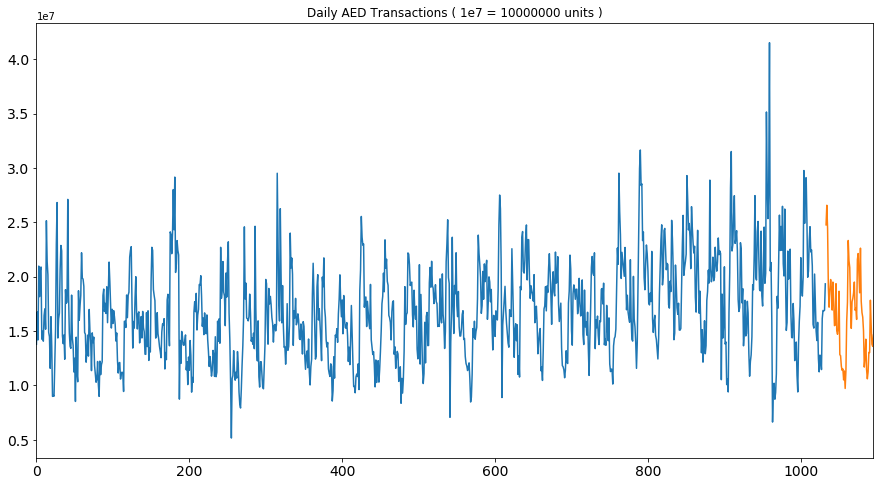

In [158]:
train.aedvolume.plot(figsize=(15,8), title= 'Daily AED Transacations', fontsize=14) #Test Data
test.aedvolume.plot(figsize=(15,8), title= 'Daily AED Transactions ( 1e7 = 10000000 units )', fontsize=14) #Train Data
plt.show()

# Using Naive Approach

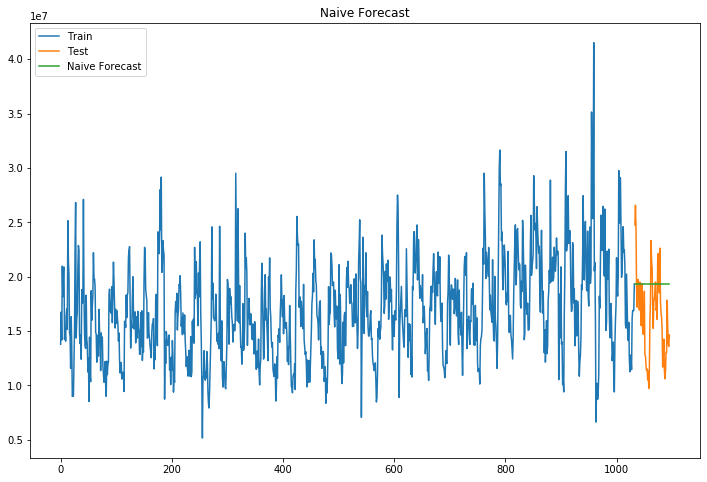

In [159]:

dd= np.asarray(train.aedvolume)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['aedvolume'], label='Train')
plt.plot(test.index,test['aedvolume'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()
plt.title('Naive')

In [160]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms1 = sqrt(mean_squared_error(test.aedvolume, y_hat.naive))
print(rms1)

# Calculate RMSE value to check to accuracy of our model on test data set. 
#The root-mean-square deviation (RMSD) or root-mean-square error (RMSE) 
#is a frequently used measure of the differences between values (sample or 
#population values) predicted by a model or an estimator and the values observed

#a value of 0 (almost never achieved in practice) would indicate a perfect fit to the data.
#In general, a lower RMSD is better than a higher one.


4778191.445974594


## Naive Approach will not work in this case as the RSME value is very high.

# Using Simple Average

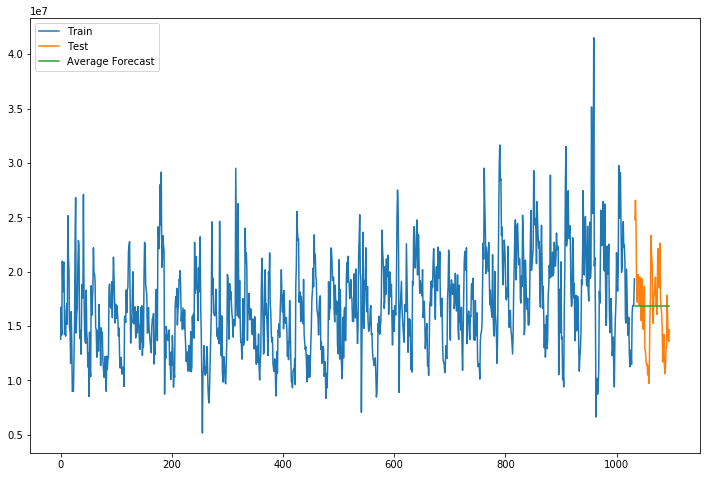

In [161]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['aedvolume'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['aedvolume'], label='Train')
plt.plot(test['aedvolume'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [162]:
rms2 = sqrt(mean_squared_error(test.aedvolume, y_hat_avg.avg_forecast))
print(rms2)

3866431.6316263736


## This appoach would not work as the RSME value is still very high

# Using Moving Average

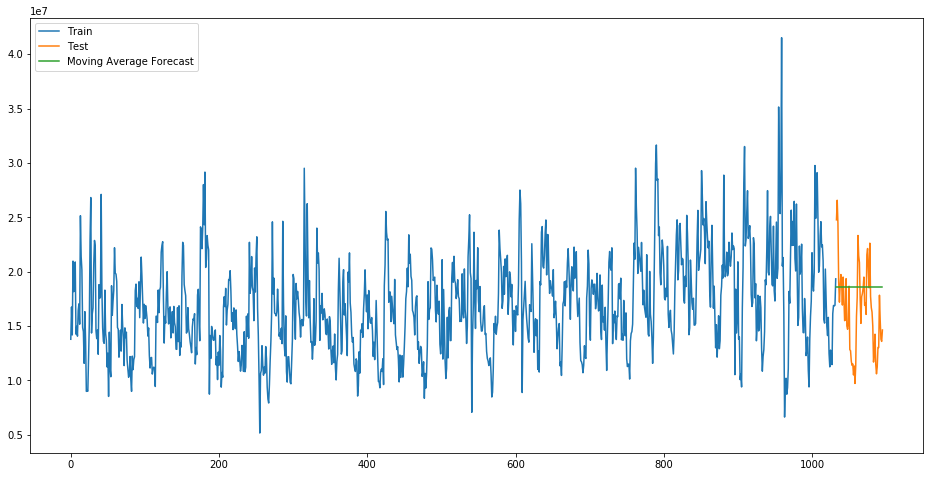

In [163]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['aedvolume'].rolling(60).mean().iloc[-1] #For last 2 months only
plt.figure(figsize=(16,8))
plt.plot(train['aedvolume'], label='Train')
plt.plot(test['aedvolume'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [164]:
rms3 = sqrt(mean_squared_error(test.aedvolume, y_hat_avg.moving_avg_forecast))
print(rms3)

4375017.450762768


# Using Simple Exponential Smoothing

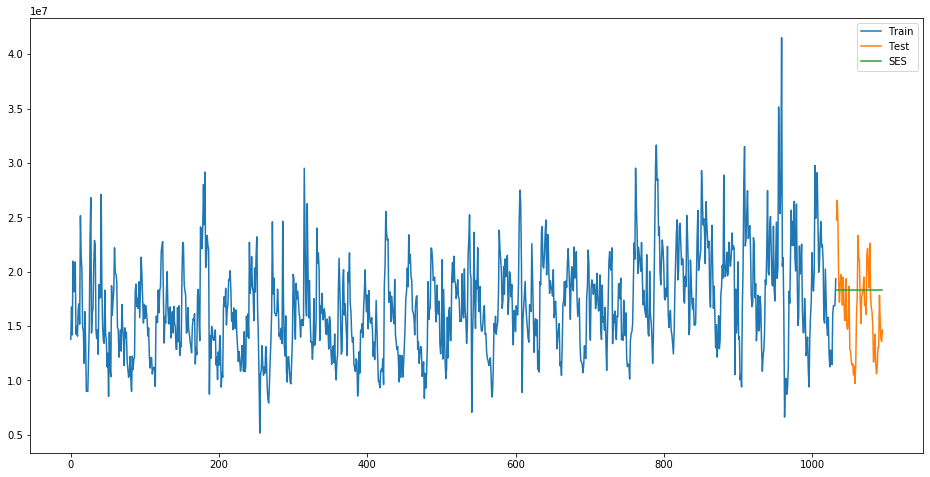

In [165]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['aedvolume'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['aedvolume'], label='Train')
plt.plot(test['aedvolume'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

#We can see that implementing Simple exponential model with alpha as 0.6 generates a better model till now.
#We can tune the parameter using the validation set to generate even a better Simple exponential model.

In [166]:
rms4 = sqrt(mean_squared_error(test.aedvolume, y_hat_avg.SES))
print(rms4)

4245519.648069493


# Using Holt's Linear Trend Model

In [167]:
train.reset_index(inplace=True)
train['date'] = pd.to_datetime(train['date'])
train = train.set_index('date')

test.reset_index(inplace=True)
test['date'] = pd.to_datetime(test['date'])
test = test.set_index('date')
s=sm.tsa.seasonal_decompose(train.aedvolume,freq=30)

#Frequency = 30 just a random number

/home/ayon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ayon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


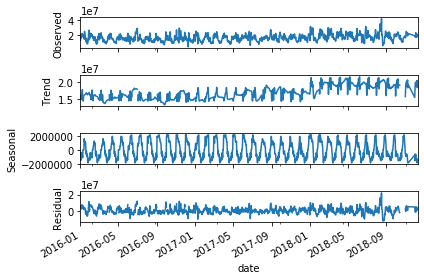

In [168]:
s.plot()
result = sm.tsa.stattools.adfuller(train.aedvolume)
plt.show()

In [169]:
#We can see from the graphs obtained that this dataset follows an increasing trend. 
#Hence we can use Holt’s linear trend to forecast the future prices.

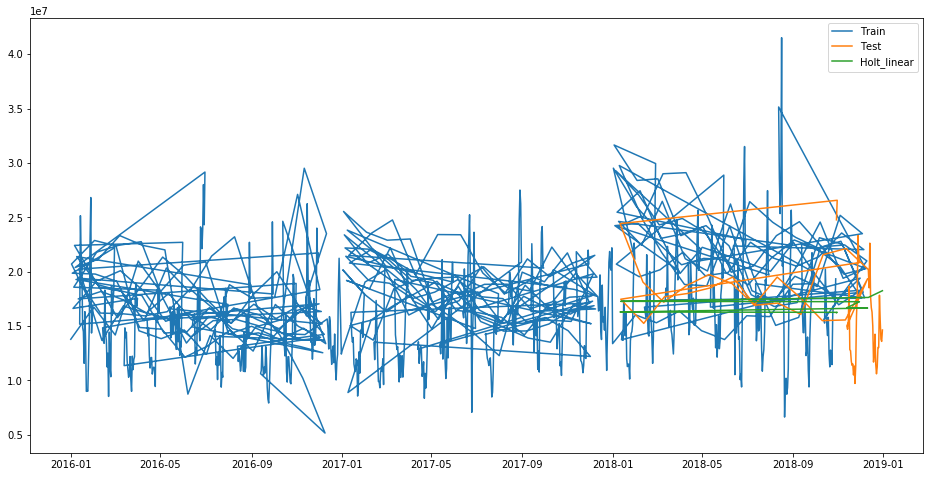

In [170]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['aedvolume'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['aedvolume'], label='Train')
plt.plot(test['aedvolume'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [171]:
rms5 = sqrt(mean_squared_error(test.aedvolume, y_hat_avg.Holt_linear))
print(rms5)

4148974.5777695505


In [172]:
print(rms1/10000000,rms2/10000000,rms3/10000000,rms4/10000000,rms5/10000000)

0.4778191445974594 0.38664316316263736 0.4375017450762768 0.42455196480694923 0.414897457776955


# Holt Winter

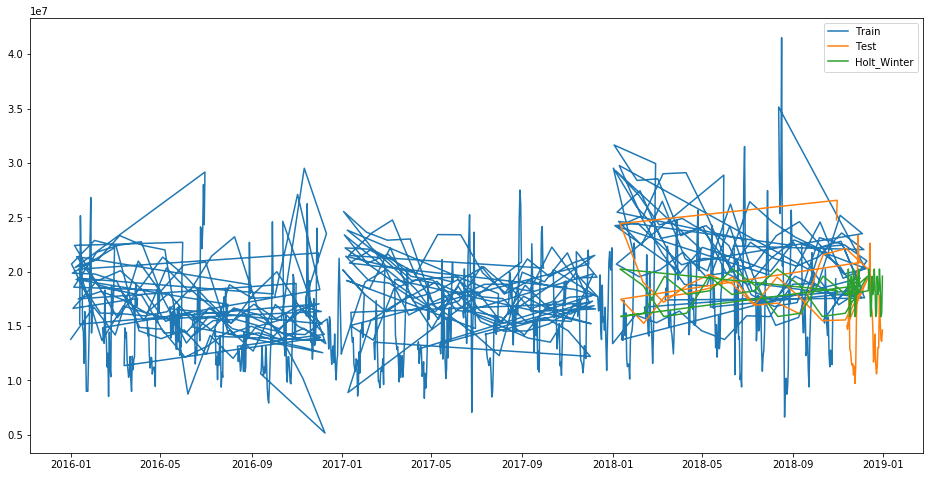

In [173]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['aedvolume']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['aedvolume'], label='Train')
plt.plot(test['aedvolume'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [174]:
rms6 = sqrt(mean_squared_error(test.aedvolume, y_hat_avg.Holt_Winter))
print(rms6/10000000)

0.4069200636903632


In [175]:
print("RSME Values for Each approaches excluding ARIMA")

print("Naive Approach :",rms1/10000000)
print("Simple Avergae :",rms2/10000000)
print("Moving Average :",rms3/10000000)
print("Simple Exponential Smoothing:",rms4/10000000)
print("Holt Linear Trend Model :",rms5/10000000)
print("Holt Winter :",rms6/10000000)

RSME Values for Each approaches excluding ARIMA
Naive Approach : 0.4778191445974594
Simple Avergae : 0.38664316316263736
Moving Average : 0.4375017450762768
Simple Exponential Smoothing: 0.42455196480694923
Holt Linear Trend Model : 0.414897457776955
Holt Winter : 0.4069200636903632


# ARIMA

In [176]:
from statsmodels import api as sm
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.aedvolume, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2016-1-1", end="2018-12-31", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['aedvolume'], label='Train')
plt.plot(test['aedvolume'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

/home/ayon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


ModuleNotFoundError: No module named 'statsmodels.base.covtype'